In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns
from IPython.display import display, Image as IPImage

In [3]:
num_cats = 3
entries_per_cat = 500

files = get_dataset_files()
files = random.sample(files, num_cats)
# files = ['./dataset/shorts.ndjson', './dataset/motorbike.ndjson', './dataset/envelope.ndjson', './dataset/suitcase.ndjson', './dataset/parrot.ndjson', './dataset/t-shirt.ndjson', './dataset/lighthouse.ndjson', './dataset/flip flops.ndjson', './dataset/speedboat.ndjson', './dataset/toothpaste.ndjson', './dataset/door.ndjson', './dataset/clarinet.ndjson', './dataset/lollipop.ndjson', './dataset/raccoon.ndjson', './dataset/microphone.ndjson', './dataset/mountain.ndjson', './dataset/traffic light.ndjson', './dataset/butterfly.ndjson', './dataset/spoon.ndjson', './dataset/spider.ndjson', './dataset/campfire.ndjson', './dataset/popsicle.ndjson', './dataset/frog.ndjson', './dataset/hot dog.ndjson', './dataset/elephant.ndjson']
data = [extract_first_entries(file, entries_per_cat, recognized=True) for file in files]
flat_data = [item for sublist in data for item in sublist]
df_loaded = pd.DataFrame.from_dict(flat_data, orient='columns')
print(f'Loaded {len(df_loaded)} entries from {files}')

image_gen_params = {
    'magnification': 4,
    'resolution': 64,
    'invert_color': True,
    'stroke_width_scale': 3
}

Loaded 1500 entries from ['./dataset/fire hydrant.ndjson', './dataset/hospital.ndjson', './dataset/foot.ndjson']


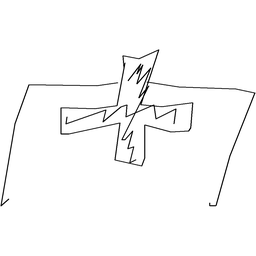

hospital


In [4]:
img = random.choice(flat_data)
display(IPImage(render_single(img['drawing'])))
print(img['word'])

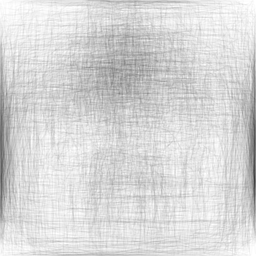

500 superimposed hospitals.


In [5]:
count = 1000 if entries_per_cat > 1000 else entries_per_cat
word = random.choice(df_loaded['word'].values)
imgs = df_loaded[df_loaded['word'] == word].sample(count)
display(IPImage(render_multiple(imgs['drawing'])))
print(f'{count} superimposed {word}s.')

In [6]:
df = df_loaded.sample(len(df_loaded))
print('Done shuffling dataset')
df = generate_pixel_columns(df, **image_gen_params)
print('Done generating pixel columns')
df = df.reset_index(drop=True)

train_amt = int(len(df) * .9)

train = df[:train_amt]
test = df[train_amt:]
# del df

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

Done shuffling dataset
Done generating pixel columns
Train: 1350 entries, test: 150 entries.


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_on = True

y = train['word'].to_numpy()
X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
print("Done generating features and target")

if pca_on:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(.85)
    X = pca.fit_transform(X)
    print(f'PCA & standardization done. Keeping {pca.n_components_} features')

save_to_disk = True

if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    with open(folder + 'img_params', 'w') as f:
        f.writelines(str(image_gen_params))
    print('Done saving dataset to disk')
    if pca_on:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(scaler, folder + 'scaler')
        print('Done saving PCA and scaler to disk')

Done generating features and target
PCA & standardization done. Keeping 240 features
Done saving dataset to disk
Done saving PCA and scaler to disk


In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_ridge import KernelRidge

# Which class does this instance belong to?
# in a multiclass classification problem can be reduced to:
#  for each class in classes:
#    does this instance belong to class? -> probability
#  return the class with the highest probability

classifiers = {
    'LinearSVC': LinearSVC(dual=False),
    'NuSVC': NuSVC(nu=.01),
    'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1),
    'SVC': SVC(kernel='rbf', C=2.5, gamma=.0001105),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(store_covariance=True),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(store_covariance=True),
    'MLPClassifier': MLPClassifier((180, 180)),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'ExtraTreeClassifier': ExtraTreeClassifier(),
    'KernelRidge': KernelRidge(),
}

models = {}
for type, classifier in classifiers.items():
    models[type] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    print(f"Done training {type} model")

if save_to_disk:
    joblib.dump(models, folder + 'models')
    print("Done saving models to disk")

/home/chris/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done training LinearSVC model
Done training NuSVC model
Done training SGDClassifier model
Done training SVC model
Done training LinearDiscriminantAnalysis model
Done training QuadraticDiscriminantAnalysis model
Done training MLPClassifier model
Done training DecisionTreeClassifier model
Done training ExtraTreeClassifier model
Done training KernelRidge model
Done saving models to disk


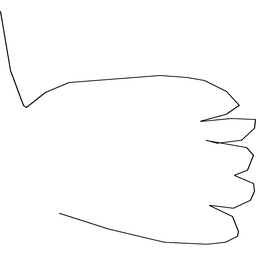

Using QuadraticDiscriminantAnalysis classifier
hospital(predicted) == foot(actual) ? False


In [9]:
cls_type, model = random.choice(list(models.items()))
# model = models['SVC']

sample = test.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(f"Using {cls_type} classifier")
print(f"{prediction[0]}(predicted) == {sample['word'].iloc[0]}(actual) ? {sample['word'].iloc[0] == prediction[0]}")

In [10]:
for model_type, model in models.items():
    test2 = test.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    if pca_on:
        test2 = scaler.transform(test2)
        test2 = pca.transform(test2)
    prediction = model.predict(test2)

    from sklearn.metrics import accuracy_score
    acc_score = accuracy_score(test['word'].values.tolist(), prediction)
    print(f"{model_type} classifier, accuracy: {acc_score}")

LinearSVC classifier, accuracy: 0.8
NuSVC classifier, accuracy: 0.9266666666666666
SGDClassifier classifier, accuracy: 0.2733333333333333
SVC classifier, accuracy: 0.9466666666666667
LinearDiscriminantAnalysis classifier, accuracy: 0.9133333333333333
QuadraticDiscriminantAnalysis classifier, accuracy: 0.88
MLPClassifier classifier, accuracy: 0.9133333333333333
DecisionTreeClassifier classifier, accuracy: 0.7533333333333333
ExtraTreeClassifier classifier, accuracy: 0.5133333333333333
KernelRidge classifier, accuracy: 0.92
